# Following a Path
Given a path, robotics has a solution for following the path. The general control scheme in robotics can be represented by the following block diagram:

![Control Block Diagram](plots/Control_Diagram.jpg)

Here the plant (or robot), generates some sort of output signal which we match against a reference signal. We take the difference to produce and error which is plugged into the controller which produces a control signal to hopefully correct for the error. If your control is good, the output signal should eventually match the reference signal. Perhaps the most obvious controller is a simple gain function which takes a scalar multiple of of the error and applies it as the control signal. A simple implementation is seen below. The agent is called the naive agent.

## Describing the simulator
While the actual preference learning project uses very fancy simulators such as GPUDrive or Nocturne, much of this tutorial will simply use matplot lib and some moving dots to represent agents. For the path following section, a green dot will represent the target location, a black line will represent the optimal path, and dots of other colors will be used to represent different solutions. The target location is not particularly important for the path following section but as the idea is to show the effectiveness of differnt control schemes given that we generated a path to get to the target. More important that getting to the target is how close it sticks to the plotted path. 

Importantly, interactive plotting via matplotlib is not supported within notebooks so where possible I will be showing static plots in the notebook and directing to a .py file in the ./simulations directory, which will be dynamic. This will usually be the first comment of the code cell.

In [5]:
# ./simulations/naive.py
import matplotlib.pyplot as plt
%matplotlib inline
import random
import math

class Agent:
    def __init__(self):
        self.x = 0
        self.y = 0
        self.positions_x = [self.x]
        self.positions_y = [self.y]
        self.color = (random.random(), random.random(), random.random())
        self.heading = (random.random() - 0.5) * 3

Here the reference signal is the x = 0 line. We calculate the error via subtracting 0 from the agent x position. Then we apply our control signal. We define a constant K_ which is the the scalar multiple and 

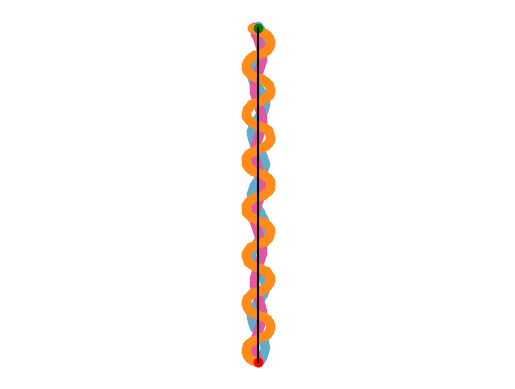

In [6]:

def naive_control(agent):
    agent.x += math.sin(agent.heading)
    agent.y += math.cos(agent.heading)
    reference = 0
    error = reference - agent.x
    K_ = 0.1
    control_signal = K_ * error
    agent.heading += control_signal

    #print(agent.x, agent.y)
    agent.positions_x.append(agent.x)
    agent.positions_y.append(agent.y)
    return agent

naive_agent1 = Agent()
naive_agent2 = Agent()
naive_agent3 = Agent()
fig, ax = plt.subplots()
plt.plot(naive_agent1.x, naive_agent1.y, 'ro') # plot a red dot to show where agents start
while naive_agent1.y < 100 or naive_agent2.y < 100 or naive_agent3.y < 100:
    # the following section differes greatly from the .py file since interactive plotting is not supported in notebooks
    # corresponding parts are commented out

    # ax.clear()
    # ax.plot(x_point, y_point, 'go')
    # ax.plot(x_line, y_line, color='black')
    if naive_agent1.y < 100:
        naive_agent1 = naive_control(naive_agent1)
    if naive_agent2.y < 100:
        naive_agent2 = naive_control(naive_agent2)
    if naive_agent3.y < 100:
        naive_agent3 = naive_control(naive_agent3)
    # ax.scatter(naive_agent.positions_x, naive_agent.positions_y, color=naive_agent.color)
    # ax.set_aspect('equal', adjustable='datalim')
    # ax.axis('off')
    # plt.draw()
    # plt.pause(0.01)
# notebook exclusive code, plotting only the final trajectory
# Plot the agent's path after the loop


# target position
x_point, y_point = 0, 100
x_line, y_line = [0, x_point], [0, y_point]
ax.plot(x_point, y_point, 'go')

# Plot the ideal path
ax.set_aspect('equal', adjustable='datalim')
ax.scatter(naive_agent1.positions_x, naive_agent1.positions_y, color=naive_agent1.color)
ax.scatter(naive_agent2.positions_x, naive_agent2.positions_y, color=naive_agent2.color)
ax.scatter(naive_agent3.positions_x, naive_agent3.positions_y, color=naive_agent3.color)
ax.plot(x_line, y_line, color='black')
ax.axis('off')
plt.show()

The naive.py file only runs one agent since it is easy to just run the file multiple times to produce multiple agents and I think it is too busy with three agents (even this static model is slightly busy). Here is the output from one of the runs from the naive.py file:

![naive plot](./plots/naive_control.png)

## Analyzing Error Dynamics
What we observe is that the controller overshoots. This is a common phenomena of all control schemes which will have an intial tendency to overshoot but ideally the error decreases over time. We can understand why over shooting example using the following thought experiment. Suppose for error $e$ it takes a control signal $u$ to correct it and for $\frac{e}{2}$ it takes a control signal of $\frac{u}{2}$. Starting at $e$ the controller applied a control signal of $u$ which if given sufficient time, would correct the error. However, by the time the plant is at $\frac{e}{2}$ the next control loop has started which added an additional $\frac{u}{2}$ control signal. This means a $u + \frac{u}{2}$ control is added to an error of only $e$ resulting in overshooting. Evidently, this is a drastic oversimplification but should give some intuition.

The naive control is extra terrible in this case as the error over time never decreases but instead it oscillates. This is because the plant does not have direct control over the error. The error is positional error but the plant (representing a car) only has control over its heading. If this is confusing, realize that parallel parking is difficult becasue you can only control the heading of the car and your car does not move laterally. This is a general problem in robotics. Imagine a robot arm with motors. The only control you have over a motor is amps which translates to torques. This means to move to a position, you need to adjust the torque at a joint. 

A general error response graph looks something like this:

![Error Response](./plots/error_curve.jpg)

All three error responses graphed are "good" given that they have a decrease in error over time and converge to 0 error. Evidently the red curve is the desired error response where the output signal very quickly converges to the reference signal creating a 0 error and has no overshooting or settling time. We also see the underdamped where the error response is too great resulting in a large overshooting and settling time, and when overdamped where the error response is too small resulting in slow convergence. We can see that our naive control is an extreme version of the underdamped system (or in our case 0 damping). 

The term damping is used as the curve represents the position response of a mass spring damper. In some sense, designing a controller is similar to picking a spring constant k and dampening constant b. Large k quickly pulls the error to 0 while a large b removes oscillation; however note that a large b inhibits pulling the error to 0 and a large k increases oscillation. We can represent the mass spring damper (and thus our error response curve) with this equation: $m\ddot{\theta}+b\dot{\theta}+k\theta=0$. Here, theta represents the position of the mass spring damper and corresponds to the vertical axis of the graph. We can generalize error dynamics to higher orders with more constants and more derivatives. This can be represented as a system of first order differential equations: $\dot{x}(t)=Ax \rightarrow x(t)=e^{At}x(0)$. To figure out if the error will converge or explode, we can find if the solutions of the system are stable or unstable. If the eigenvalues of matrix $A$ have all negative real components, then the error will decrease over time; it is said in this case that the error dynamics are stable.

If we return to this second order equation: $m\ddot{\theta}+b\dot{\theta}+k\theta=0$. It is common to let $m=0$ to create the first order equation $\dot{\theta}+\frac{k}{b}\theta=0$. If we define a time constant $T = b/k\rightarrow \dot{\theta}+\frac{1}{T} \rightarrow \theta(t)=e^{-t/T}\theta(0)$. This equation is stable when T is positive. In this case, it is decaying exponential over time. This confirms the statement made before: "large k quickly pulls the error to 0 ... however ... a large b inhibits pulling the error to 0". Given this information, we can solve for the 2% settling time or the amount of time for the error to decrease to 2% of the intial error via solving this equation: $e^{-t/T}=0.02 \rightarrow t \approx 4T$.

The graph shown above highlights the error response for an underdamped, overdamped, and critically damped error dynamic which corresponds to complex, real, and repeated roots of the characteristic equations of the second order equation. The details of this derivation are not critical to understanding the rest of this notebook.

## Open Loop Control
Perhaps an even simpler for of control is for the plant to simply command the desired trajectory. In this case the optimal trajectory is to go straight and the AV can simply go straight without regard to complicated control theory. More generally, any trajectory can be simplified into a list of actions, even something as complicated as parallel parking can be simplified into a series of wheels turn angles and rotations of the wheel that the car can simply command. We will see such an implementation below.

In [7]:
# ./simulations/open_loop.py
class Open_Loop_Agent(Agent):
    def __init__(self):
        super().__init__()
        self.heading = 0

def open_loop_control(agent):
    agent.x += math.sin(agent.heading)
    agent.y += math.cos(agent.heading)
    agent.positions_x.append(agent.x)
    agent.positions_y.append(agent.y)
    return agent

The open_loop_control function merely makes the car move forward with no regard to the error. Notice how there is no sensing of the actual location. There is no sensing to close the feedback loop thus the name open loop. We can see the loop in the original control scheem block diagram where the output signal is looped back to be compared with the reference signal. While I will conceed that this example will work great in the previous simulation, the lack of feedback control means any error or disturbance the state transition and the plant will not be able to recover. Below is a simple disturbance function which simulates hitting a rock or any other road disturbance. Real cars will internal mechanical errors which prevents the car from ever rotating the wheel exactly 1 revolution as opposed to 1.1 or 0.9. This error will accumulate over time. 

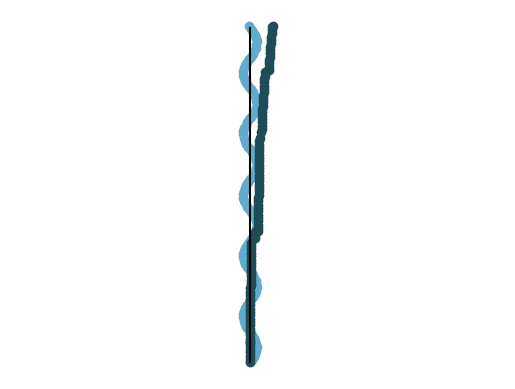

In [9]:

def disturbance(agent):
    agent.x += (random.random() - 0.3)*2
    agent.y += (random.random() - 0.5)*2
    agent.heading += (random.random() - 0.3)*0.05
    return agent

naive_agent = Agent()
open_loop_agent = Open_Loop_Agent()
fig, ax = plt.subplots()

# # target position
# x_point, y_point = 0, 100
# x_line, y_line = [0, x_point], [0, y_point]
# ax.plot(x_point, y_point, 'go')

# # Plot the ideal path
# ax.plot(x_line, y_line, color='black')
# ax.axis('off')

# ax.set_aspect('equal', adjustable='datalim')
# starting_position = Agent()
# plt.plot(starting_position.x, starting_position.y, 'ro') # plot a red dot to show where agents start
while naive_agent.y < 100 or open_loop_agent.y < 100:
    # ax.clear()
    # ax.plot(x_point, y_point, 'go')
    # ax.plot(x_line, y_line, color='black')
    if naive_agent.y < 100:
        naive_agent = naive_control(naive_agent)
    # ax.scatter(naive_agent.positions_x, naive_agent.positions_y, color=naive_agent.color)
    if open_loop_agent.y < 100:
        open_loop_agent = open_loop_control(open_loop_agent)
    # ax.scatter(open_loop_agent.positions_x, open_loop_agent.positions_y, color=open_loop_agent.color)

    if random.random() < 0.1:
        naive_agent = disturbance(naive_agent)
        open_loop_agent = disturbance(open_loop_agent)
    # ax.set_aspect('equal', adjustable='datalim')
    # ax.axis('off')
    # plt.draw()
    # plt.pause(0.01)

ax.set_aspect('equal', adjustable='datalim')
ax.scatter(naive_agent1.positions_x, naive_agent1.positions_y, color=naive_agent1.color)
ax.scatter(open_loop_agent.positions_x, open_loop_agent.positions_y, color=open_loop_agent.color)
ax.plot(x_line, y_line, color='black')
ax.axis('off')
plt.show()

There is a clear difference. Despite the disturbance being applied to both agents, and closed loop naive control is able to recover (albeit its performance is still not great for the reasons described before) while the error increases over time on the open loop agent. Here is the result from running open_loop.py:

![open vs closed loop](plots/open_loop.png)

There is a clear rightwards lean in the open loop solution. This is because the disturbance function was designed to push agents towards the right. If the disturbance function was say a gaussian noise function centered at 0, the 0 average would not make the error accumulation apparent in this short example.  

# PID
The naive controller that was implemented previously can be more accurately be called a proportional or P controller which is characterized by $\dot{\theta}(t) = K_p(\theta_d(t)-\theta(t)) = K_p\theta_e(t)$ where $\dot{\theta}(t)$ is the plant velocity, $K_p$ is a proportional gain, $\theta_d(t)-\theta(t)$ is the difference in desired position versus actual position which can be represented by the error or $\theta_e(t)$. As described previously, if the plant is a car, it has no direct control over its lateral velocity and thus a heading control is applied instead to simulate applying a velocity to correct for the error. We can also formalize the notion that proportional control will lead non-zero error. The equations in the discussion will not perfectly model our plant due to complications discussed previously but provide general insight on why P control is not sufficients.

Our trajectory demands a constant velocity, going forward which can be represented as $\dot{\theta_d}(t)=c$ where $c$ is a constant. If we model the error dynamics $\dot{\theta_e}(t)=\dot{\theta}_d(t)-\dot{\theta}(t)= c-K_p\theta_e(t)$ and then solve the differiential equation, the result is $\theta_e(t)=\frac{c}{K_p}+(\theta_e(0)-\frac{c}{K_p})e^{-K_pt}$. As time approaches infinity, there is a steady state error of $\frac{c}{K_p}$. This cannot be resolved by choosing $K_p$ to approach infinity as this would require the robot to be able to move at infinite velocity; there are many practical concerns related to choosing large $K_p$ mostly related to how mechanical systems to not like jerking extremely quickly. 

Improving the error response requires adding additional controllers. An obvious place to look is the original mass spring damper equation: $m\ddot{\theta}+b\dot{\theta}+k\theta=0$. Lets once again ignore the $m$ term but in this case by setting it to 1. As explained previously, $\dot{\theta}(t) = K_p\theta_e(t)$ which hints at the need for an integral term to fulfill the $k\theta$ term of the equation. Indeed, if we redefined $\dot{\theta}(t) = K_p\theta_e(t)+K_i\int_0^t\theta_e(t)dt\rightarrow\dot{\theta}_d=\dot{\theta}_e(t)+K_p\theta_e(t)+K_i\int_0^t\theta_e(t)dt = c$, where $K_i$ i the integral gain, then take derivatives on both sides, we get a form matching the mass spring damper equation: $\ddot{\theta_e}(t)+K_p\dot{\theta}(t)+K_i\theta_e(t)=0$ where $K_p$ is the damper and $K_i$ is the spring. For reasons explained before, if $K_i$ and $K_p$ are positive then the error dynamics are stable and the steady state error is 0. This formulation is called a PI or proportional integral controller. We have concluded that for all trajectories of constant velocity, a PI control is sufficient. However, it is not sufficient on arbitary trajectories where the velocity is not constant such as trajectories that include sharp turns where practically, safety, and other considerations prevent maintaining a constant velocity. 

One problem with PI control is that the plant does not move if there is no error. Given that we know the desired velocity, we should be able to make the robot move without waiting for an accumulation of error. We can simply command the robot to move at the desired velocity if there is no error represented by $\dot{\theta}(t) = \dot{\theta}_d + K_p\theta_e(t)+K_i\int_0^t\theta_e(t)dt$. It should be evident why the control loop is called PID or proportional integral derivative control now. True PID control is actually represented by $\tau = K_p\theta_e + K_i\int\theta_e(t)dt + K_d\dot{\theta}_e$ and the control loop described above is called feed forward PI control. The derivation of PID controll is too robotics specific and is not needed for the understanding of the rest of the notebook. PID control generalizes to all applications presented in this notebook as in real robots/vehicles, the control systems only have control over motor torques and not motor velocity (note how PID control is defined for $\tau$). For applications where there are low stakes, the I term is often set to 0 creating PD control. This is because the steady state error does not matter for low stakes applications. Similarly, for applications where steady state error cannot be removed such as robots which balance on two wheels, the I term can be set to 0 since physics prevents perfectly stable balancing thus there will always be steady state error. 

The following PID demonstrator will be run using webot simulation, an alternative to gazebo. Install webot following these instructions: [webot installation](https://cyberbotics.com/doc/guide/installation-procedure)